In [1]:
import os
import re
import sys
import json
import warnings
import matplotlib
import subprocess
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
import matplotlib.colors as mcolors
import matplotlib.transforms as mtransforms

from scipy.optimize import curve_fit
from scipy.stats import percentileofscore

sys.path.append('../modules')
import plot_optimal_window as plt_ow
import plot_temporal_fluctuation_scaling as plt_tfs
import estimate_temporal_fluctuation_scaling as etfs

warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)

colors = ["blue", "green", "red", "purple", "orange", "brown", "pink", "olive", "gray", "cyan"]

In [2]:
%matplotlib inline

## Global variables

In [3]:
input_path_raw = "../input_files/raw_data"
input_path_processed = "../input_files/processed_data"
input_path_data_dictionary = "../input_files/data_dictionary"
log_path = "../logs"
output_path = "../output_files"
input_generation_date = "2023-11-07"

In [4]:
delta_t = 0.0001
n_points = 2 ** 14
n_simulations = 4.1 * (10 ** 3)
n_aux = 0
np.random.seed(1)
x0 = 0
mu = 3 * (10 ** 1)
b0 = -mu# * (10 ** -2)
omega = 1
delta = 1
sigma = 3 * (10 ** 0)

# Generate toy model data

\begin{gather}
    dX_{t} = f(t)dt + g(t)dW_{t}\\
    M_{1}(t) = \int_{t_{0}}^{t} f(\tau)d\tau\\
    \Xi_{2}(t) = \int_{t_{0}}^{t} g^{2}(\tau) d\tau
\end{gather}

In [5]:
def drift_coefficient(t, mu, b0, omega, delta):
    return mu + (b0 * omega) / (omega * t + delta)

def generate_tfs_toy_model_data(
    x0,
    mu,
    b0,
    omega,
    delta,
    sigma,
    delta_t,
    n_points,
    n_simulations
):
    """Generate multiple sample path of modified brownian motion with logarithmic drift (BML)
    Generate multiple simulations of fBm with the same amount of points and same parameters:
        x0: Initial condition of stochastic path
        mu: Stochastic drift of the model
        b0: Amplitude of the Hamiltonian of temporal fluctuation scaling
        omega: Frequency of the Hamiltonian of temporal fluctuation scaling
        delta: Phase of the Hamiltonian of temporal fluctuation scaling
        sigma: Diffusion coefficient
        delta_t: Integration time of stochastic process
        n_points: Number of steps in path sample
        n_simulations: Number of simulations
    """
    # The time array of the trajectory
    time = np.arange(0, delta_t * n_points, delta_t)
        
    # Iteration process
    df_sample = []
    n_sim = 1
    while n_sim <= n_simulations:
        # Modified Brownian motion with logarithmic drift (BML)
        dy = drift_coefficient(t = time, mu = mu, b0 = b0, omega = omega, delta = delta) * delta_t + sigma * np.random.normal(0, np.sqrt(delta_t), size = len(time))
        y = x0 + np.cumsum(dy)

        # Dataframe local
        df_local = pd.DataFrame(
            {
                "symbol" : ["BML_simulation_{}".format(n_sim)] * len(y),
                "ticker_name" : ["Modified Brownian motion (BML) N={}".format(n_sim)] * len(y),
                "date" : time,
                "step" : np.arange(len(y)),
                "log_return" : y
            }
        )

        # Estimate absolute log-return ----
        df_local["absolute_log_return"] = np.abs(df_local["log_return"])

        # Estimate log-return volatility ----
        df_temp_1 = df_local.rename(columns = {"absolute_log_return" : "temp_1"}).groupby(["symbol"])["temp_1"].max()
        df_local = df_local.merge(df_temp_1, left_on = "symbol", right_on = "symbol")
        df_local["z_score"] = df_local[["absolute_log_return"]].apply(lambda x: (x - np.mean(x)) / np.std(x))
        df_local["log_volatility"] = np.sqrt(np.abs(df_local["z_score"])) / df_local["temp_1"]

        # Replace NaN with zeros ----
        df_local["log_return"] = df_local["log_return"].fillna(0)
        df_local["absolute_log_return"] = df_local["absolute_log_return"].fillna(0)
        df_local["log_volatility"] = df_local["log_volatility"].fillna(0)

        # Estimate cumulative sum of log-return, absolute log-return and log-return volatility ----
        df_local["cum_log_return"] = df_local["log_return"].cumsum()
        df_local["cum_absolute_log_return"] = df_local["absolute_log_return"].cumsum()
        df_local["cum_log_volatility"] = df_local["log_volatility"].cumsum()

        # Estimate cumulative mean of log-return, absolute log-return and log-return volatility ----
        df_local["cummean_log_return"] = df_local["log_return"].rolling(df_local.shape[0], min_periods = 1).mean()
        df_local["cummean_absolute_log_return"] = df_local["absolute_log_return"].rolling(df_local.shape[0], min_periods = 1).mean()
        df_local["cummean_log_volatility"] = df_local["log_volatility"].rolling(df_local.shape[0], min_periods = 1).mean()

        # Estimate cumulative variance of log-return, absolute log-return and log-return volatility ----
        df_local["cumvariance_log_return"] = df_local["log_return"].rolling(df_local.shape[0], min_periods = 2).var()
        df_local["cumvariance_absolute_log_return"] = df_local["absolute_log_return"].rolling(df_local.shape[0], min_periods = 2).var()
        df_local["cumvariance_log_volatility"] = df_local["log_volatility"].rolling(df_local.shape[0], min_periods = 2).var()

        # Append simulation to final dataframe
        df_sample.append(df_local.fillna(0))

        n_sim += 1
    
    df_sample = pd.concat(df_sample)
    del [df_sample["temp_1"], df_sample["z_score"]]
    
    return df_sample

In [6]:
df_local = generate_tfs_toy_model_data(
    x0 = x0,
    mu = mu,
    b0 = b0,
    omega = omega,
    delta = delta,
    sigma = sigma,
    delta_t = delta_t,
    n_points = n_points,
    n_simulations = n_simulations
)

df_local

,symbol,ticker_name,date,step,log_return,absolute_log_return,log_volatility,cum_log_return,cum_absolute_log_return,cum_log_volatility,cummean_log_return,cummean_absolute_log_return,cummean_log_volatility,cumvariance_log_return,cumvariance_absolute_log_return,cumvariance_log_volatility
0,BML_simulation_1,Modified Brownian motion (BML) N=1,0.0000,0,0.048730,0.048730,0.047443,0.048730,0.048730,0.047443,0.048730,0.048730,0.047443,0.000000,0.000000,0.000000e+00
1,BML_simulation_1,Modified Brownian motion (BML) N=1,0.0001,1,0.030378,0.030378,0.047485,0.079108,0.079108,0.094928,0.039554,0.039554,0.047464,0.000168,0.000168,8.632450e-10
2,BML_simulation_1,Modified Brownian motion (BML) N=1,0.0002,2,0.014533,0.014533,0.047521,0.093642,0.093642,0.142449,0.031214,0.031214,0.047483,0.000293,0.000293,1.500209e-09
3,BML_simulation_1,Modified Brownian motion (BML) N=1,0.0003,3,-0.017655,0.017655,0.047514,0.075987,0.111296,0.189962,0.018997,0.027824,0.047491,0.000792,0.000241,1.235567e-09
4,BML_simulation_1,Modified Brownian motion (BML) N=1,0.0004,4,0.008309,0.008309,0.047535,0.084296,0.119605,0.237497,0.016859,0.023921,0.047499,0.000617,0.000257,1.316499e-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16379,BML_simulation_4100,Modified Brownian motion (BML) N=4100,1.6379,16379,17.506880,17.506880,0.085324,93581.547434,99626.212470,834.036385,5.713159,6.082186,0.050918,30.351154,25.998086,2.991334e-04
16380,BML_simulation_4100,Modified Brownian motion (BML) N=4100,1.6380,16380,17.513942,17.513942,0.085350,93599.061375,99643.726412,834.121736,5.713880,6.082884,0.050920,30.357803,26.004476,2.991875e-04
16381,BML_simulation_4100,Modified Brownian motion (BML) N=4100,1.6381,16381,17.462652,17.462652,0.085158,93616.524028,99661.189064,834.206894,5.714597,6.083579,0.050922,30.364375,26.010794,2.992408e-04
16382,BML_simulation_4100,Modified Brownian motion (BML) N=4100,1.6382,16382,17.483100,17.483100,0.085235,93634.007128,99678.672164,834.292129,5.715315,6.084275,0.050924,30.370976,26.017138,2.992944e-04


In [7]:
df_toy_model = df_local

df_toy_model = df_toy_model.groupby(["date", "step"]).agg(
    log_return = ("log_return", "mean"),
    absolute_log_return = ("absolute_log_return", "mean"),
    log_volatility = ("log_volatility", "mean"),
    cum_log_return = ("cum_log_return", "mean"),
    cum_absolute_log_return = ("cum_absolute_log_return", "mean"),
    cum_log_volatility = ("cum_log_volatility", "mean"),
    cummean_log_return = ("cummean_log_return", "mean"),
    cummean_absolute_log_return = ("cummean_absolute_log_return", "mean"),
    cummean_log_volatility = ("cummean_log_volatility", "mean"),
    cumvariance_log_return = ("cumvariance_log_return", "mean"),
    cumvariance_absolute_log_return = ("cumvariance_absolute_log_return", "mean"),
    cumvariance_log_volatility = ("cumvariance_log_volatility", "mean")
).reset_index()

#df_toy_model["log_return"] = df_toy_model["log_return"] - df_toy_model["log_return"].min()
#df_toy_model["cum_log_return"] = df_toy_model["log_return"].cumsum()

df_toy_model["symbol"] = "BML_simulation"
df_toy_model["ticker_name"] = "Modified Brownian motion (BML)"
df_toy_model

,date,step,log_return,absolute_log_return,log_volatility,cum_log_return,cum_absolute_log_return,cum_log_volatility,cummean_log_return,cummean_absolute_log_return,cummean_log_volatility,cumvariance_log_return,cumvariance_absolute_log_return,cumvariance_log_volatility,symbol,ticker_name
0,0.0000,0,0.000043,0.024522,0.057956,0.000043,0.024522,0.057956,0.000043,0.024522,0.057956,0.000000,0.000000,0.000000e+00,BML_simulation,Modified Brownian motion (BML)
1,0.0001,1,-0.000023,0.034576,0.057913,0.000020,0.059098,0.115869,0.000010,0.029549,0.057935,0.000457,0.000331,7.600559e-09,BML_simulation,Modified Brownian motion (BML)
2,0.0002,2,-0.000493,0.042022,0.057882,-0.000473,0.101120,0.173751,-0.000158,0.033707,0.057917,0.000608,0.000441,1.039035e-08,BML_simulation,Modified Brownian motion (BML)
3,0.0003,3,-0.000227,0.048617,0.057857,-0.000700,0.149737,0.231609,-0.000175,0.037434,0.057902,0.000764,0.000551,1.236100e-08,BML_simulation,Modified Brownian motion (BML)
4,0.0004,4,0.000013,0.053924,0.057834,-0.000686,0.203661,0.289443,-0.000137,0.040732,0.057889,0.000903,0.000656,1.438517e-08,BML_simulation,Modified Brownian motion (BML)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16379,1.6379,16379,20.019506,20.019506,0.073281,126417.400106,128941.393518,740.876451,7.717790,7.871880,0.045231,39.869302,38.075591,2.440531e-04,BML_simulation,Modified Brownian motion (BML)
16380,1.6380,16380,20.021215,20.021215,0.073286,126437.421321,128961.414733,740.949737,7.718541,7.872622,0.045232,39.876412,38.082590,2.440919e-04,BML_simulation,Modified Brownian motion (BML)
16381,1.6381,16381,20.023081,20.023081,0.073291,126457.444402,128981.437814,741.023028,7.719292,7.873363,0.045234,39.883523,38.089589,2.441307e-04,BML_simulation,Modified Brownian motion (BML)
16382,1.6382,16382,20.025155,20.025155,0.073298,126477.469557,129001.462969,741.096326,7.720043,7.874105,0.045236,39.890635,38.096590,2.441695e-04,BML_simulation,Modified Brownian motion (BML)


In [8]:
df_toy_model_parameters = etfs.estimate_tfs_parameters(
    df_fts = df_toy_model,
    minimal_steps = 30,
    p_norm = 1,
    log_path = log_path,
    log_filename = "log_toy_model_tfs_optimal_window_{}".format(re.sub("-", "", input_generation_date)),
    verbose = 1,
    tqdm_bar = True
)
df_toy_model_parameters

100%|█████████████████| 16354/16354 [08:07<00:00, 33.57it/s]


,symbol,max_step,time_series,p_norm,coefficient_tfs,error_coefficient_tfs,exponent_tfs,error_exponent_tfs,average_error_tfs,rsquared_tfs
0,BML_simulation,30,log-return,1,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000
1,BML_simulation,30,absolute log-return,1,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000
2,BML_simulation,30,log-return volatility,1,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000
3,BML_simulation,31,log-return,1,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000
4,BML_simulation,31,absolute log-return,1,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
49057,BML_simulation,16382,absolute log-return,1,6.214324e-01,2.864952e-04,1.997243,0.000248,0.088869,0.999913
49058,BML_simulation,16382,log-return volatility,1,1.188482e-12,1.225316e-13,-5.932809,0.032490,0.000028,0.829024
49059,BML_simulation,16383,log-return,1,NaN,inf,NaN,inf,NaN,NaN
49060,BML_simulation,16383,absolute log-return,1,6.214433e-01,2.864842e-04,1.997232,0.000248,0.088879,0.999913


In [9]:
df_toy_model_parameters[((df_toy_model_parameters["time_series"] == "log-return") & (~df_toy_model_parameters["exponent_tfs"].isnull()))]

,symbol,max_step,time_series,p_norm,coefficient_tfs,error_coefficient_tfs,exponent_tfs,error_exponent_tfs,average_error_tfs,rsquared_tfs
0,BML_simulation,30,log-return,1,0.0,0.0,0.0,0.0,0.0,0.0
3,BML_simulation,31,log-return,1,0.0,0.0,0.0,0.0,0.0,0.0
6,BML_simulation,32,log-return,1,0.0,0.0,0.0,0.0,0.0,0.0
9,BML_simulation,33,log-return,1,0.0,0.0,0.0,0.0,0.0,0.0
12,BML_simulation,34,log-return,1,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
29394,BML_simulation,9828,log-return,1,0.0,0.0,0.0,0.0,0.0,0.0
29526,BML_simulation,9872,log-return,1,0.0,0.0,0.0,0.0,0.0,0.0
29832,BML_simulation,9974,log-return,1,0.0,0.0,0.0,0.0,0.0,0.0
29922,BML_simulation,10004,log-return,1,0.0,0.0,0.0,0.0,0.0,0.0


# Final relation

In [10]:
def prepare_data(
    df_fts,
    df_tfs,
    interval,
    threshold_tfs=0.9 
):
    """Preparation of data for plotting
    Join original data with optimal window size data:
        df_fts: Dataframe with multiple financial time series
        df_tfs: Dataframe with temporal fluctuation scaling parameters
        interval: Select transformation for estimation of time between minimum and maximum date
        threshold_tfs: Threshold of determination coefficient of temporal fluctuation scaling (TFS)
    """
    
    # Estimation of interval of time for each ticker ----
    df_fts["min_date"] = pd.to_datetime(df_fts.groupby(["symbol"])["date"].transform("min"), errors = "coerce", infer_datetime_format = True)
    df_fts["max_date"] = pd.to_datetime(df_fts.groupby(["symbol"])["date"].transform("max"), errors = "coerce", infer_datetime_format = True)
    
    interval_dict = {"years" : "Y", "months" : "M", "weeks" : "W", "days" : "D", "hours" : "h", "minutes" : "m", "seconds" : "s", "milliseconds" : "ms"}
    df_fts["duration"] = (df_fts["max_date"] - df_fts["min_date"]) / np.timedelta64(1, interval_dict[interval])
    df_dates = df_fts[["symbol", "min_date", "max_date", "duration"]].drop_duplicates(["symbol", "min_date", "max_date", "duration"])
    
    # Log-return data ----
    df_logr = (
        df_fts[["date", "symbol", "step", "cummean_log_return", "cumvariance_log_return"]]
            .rename(columns = {"cummean_log_return" : "cummean", "cumvariance_log_return" : "cumvariance"})
    )
    df_logr["time_series"] = "log-return"
    
    # Absolute log-return data ----
    df_loga = (
        df_fts[["date", "symbol", "step", "cummean_absolute_log_return", "cumvariance_absolute_log_return"]]
            .rename(columns = {"cummean_absolute_log_return" : "cummean", "cumvariance_absolute_log_return" : "cumvariance"})
    )
    df_loga["time_series"] = "absolute log-return"
    
    # Log-return volatility data ----
    df_logv = (
        df_fts[["date", "symbol", "step", "cummean_log_volatility", "cumvariance_log_volatility"]]
            .rename(columns = {"cummean_log_volatility" : "cummean", "cumvariance_log_volatility" : "cumvariance"})
    )
    df_logv["time_series"] = "log-return volatility"
    
    # Merge final data (Hurst exponent and Temporal Theil Scaling (TTS)) ----
    df_plot_data = (
        pd.concat([df_logr, df_loga, df_logv])
            .merge(df_dates, left_on = ["symbol"], right_on = ["symbol"])
            .merge(df_tfs, left_on = ["symbol", "time_series", "step"], right_on = ["symbol", "time_series", "max_step"])
    )
    
    df_plot_data["coefficient_tfs"].replace([np.inf, -np.inf], np.nan, inplace = True)
    df_plot_data = df_plot_data[(df_plot_data["exponent_tfs"] != 0)]    
    df_plot_data = df_plot_data[df_plot_data["rsquared_tfs"] >= threshold_tfs]
    
    del [df_plot_data["max_step"]]
        
    return df_plot_data

In [11]:
df_final = prepare_data(
    df_fts = df_toy_model,
    df_tfs = df_toy_model_parameters,
    interval = "days",
    threshold_tfs = 0.91
)
print(len(df_final[df_final["time_series"] == "log-return"]))
df_final

0


,date,symbol,step,cummean,cumvariance,time_series,min_date,max_date,duration,p_norm,coefficient_tfs,error_coefficient_tfs,exponent_tfs,error_exponent_tfs,average_error_tfs,rsquared_tfs
25548,0.9224,BML_simulation,9224,3.265026,6.574037,absolute log-return,1970-01-01,1970-01-01 00:00:00.000000001,1.157407e-14,1,5.271134e-01,2.112596e-04,2.140585,0.000404,0.018253,0.999863
25551,0.9227,BML_simulation,9227,3.266596,6.580524,absolute log-return,1970-01-01,1970-01-01 00:00:00.000000001,1.157407e-14,1,5.271515e-01,2.113981e-04,2.140489,0.000404,0.018277,0.999863
25553,0.9229,BML_simulation,9229,3.267643,6.584850,absolute log-return,1970-01-01,1970-01-01 00:00:00.000000001,1.157407e-14,1,5.271769e-01,2.114904e-04,2.140424,0.000404,0.018293,0.999863
25558,0.9234,BML_simulation,9234,3.270260,6.595670,absolute log-return,1970-01-01,1970-01-01 00:00:00.000000001,1.157407e-14,1,5.272404e-01,2.117210e-04,2.140263,0.000404,0.018333,0.999863
25560,0.9236,BML_simulation,9236,3.271307,6.600002,absolute log-return,1970-01-01,1970-01-01 00:00:00.000000001,1.157407e-14,1,5.272659e-01,2.118131e-04,2.140199,0.000404,0.018349,0.999863
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48103,1.5425,BML_simulation,15425,0.043669,0.000212,log-return volatility,1970-01-01,1970-01-01 00:00:00.000000001,1.157407e-14,1,1.966506e-13,1.662736e-14,-6.485875,0.026592,0.000022,0.910266
48104,1.5426,BML_simulation,15426,0.043670,0.000212,log-return volatility,1970-01-01,1970-01-01 00:00:00.000000001,1.157407e-14,1,1.969824e-13,1.664090e-14,-6.485357,0.026598,0.000022,0.910212
48105,1.5427,BML_simulation,15427,0.043672,0.000212,log-return volatility,1970-01-01,1970-01-01 00:00:00.000000001,1.157407e-14,1,1.972499e-13,1.667230e-14,-6.484943,0.026603,0.000022,0.910159
48106,1.5428,BML_simulation,15428,0.043673,0.000212,log-return volatility,1970-01-01,1970-01-01 00:00:00.000000001,1.157407e-14,1,1.975469e-13,1.669582e-14,-6.484482,0.026608,0.000022,0.910105


time_series
absolute log-return    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

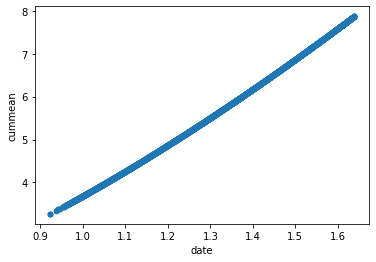

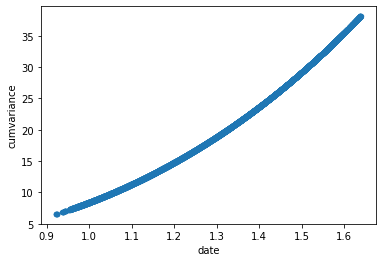

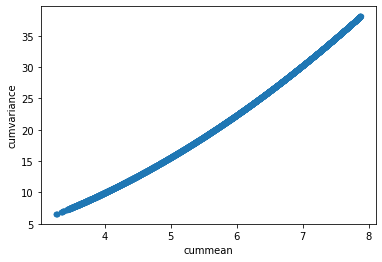

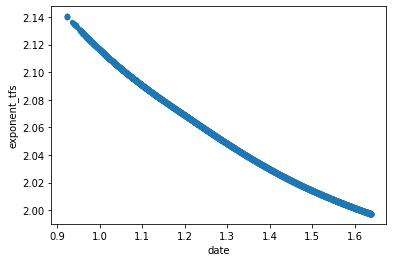

In [12]:
A = df_final[df_final["time_series"] == "absolute log-return"]
A.groupby(["time_series"]).plot(kind = "scatter", x = "date", y = "cummean", legend = True)
A.groupby(["time_series"]).plot(kind = "scatter", x = "date", y = "cumvariance", legend = True)
A.groupby(["time_series"]).plot(kind = "scatter", x = "cummean", y = "cumvariance", legend = True)
A.groupby(["time_series"]).plot(kind = "scatter", x = "date", y = "exponent_tfs", legend = True)

In [13]:
# Theoretical evolution of the mean with Modified Brownian motion of parameters mu and b0 ----
def mean_evolution_0(t, mu, b0, sigma):
    """Estimation of mean evolution
    Estimation of mean evolution with Modified Brownian motion of parameters mu and b0:
        t: Time
        mu: Stochastic drift of the model
        b0: Amplitude of the Hamiltonian of temporal fluctuation scaling
        delta: Phase of the Hamiltonian of temporal fluctuation scaling
        sigma: Diffusion coefficient
    """
    # Estimate mean
    z = mu * t + b0 * np.log(t + 1) + sigma * np.sqrt(2 * t / np.pi)
    
    return z

# Theoretical evolution of the variance with Modified Brownian motion of parameter sigma ----
def variance_evolution_0(t, mu, b0, sigma):
    """Estimation of mean evolution
    Estimation of mean evolution with Modified Brownian motion of parameters mu and b0:
        t: Time
        mu: Stochastic drift of the model
        b0: Amplitude of the Hamiltonian of temporal fluctuation scaling
        sigma: Diffusion coefficient
    """
    # Estimate variance
    z = np.power(sigma, 2) * (1 - 2 / np.pi) * t - 2 * sigma * np.sqrt(2 * t / np.pi) * (mu * t + b0 * np.log(t + 1))
    
    return z

# Estimation of p-norm ----
def estimate_p_norm(x, y, p):
    if p == 0:
        z = np.exp(0.5 * np.mean(np.log(np.power(np.abs(x-y), 2))))
    else:
        z = np.power(np.abs(x - y), 1 / p)
    return np.mean(z)

# Plot evolution of tfs parameters for toy model ----
def plot_tfs_toy_model(
    df_fts,
    df_tfs,
    interval,
    threshold,
    symbols,
    mu,
    b0,
    sigma,
    p_norm,
    width,
    height,
    markersize = 2,
    fontsize_labels = 13.5,
    fontsize_legend = 11.5,
    usetex = False,
    n_cols = 4,
    n_x_breaks = 10,
    n_y_breaks = 10,
    fancy_legend = True,
    dpi = 150,
    save_figures = True,
    output_path = "../output_files",
    information_name = "",
    input_generation_date = "2023-03-28"
):
    """Preparation of data for plotting
    Join original data with optimal window size data:
        df_fts: Dataframe with multiple financial time series
        df_tfs: Dataframe with temporal fluctuation scaling parameters
        interval: Select transformation for estimation of time between minimum and maximum date
        threshold: Threshold for estimation of inverse percentile function (percentage of data with R2 >= threshold)
        symbols: Symbols of the financial time series plotted
        mu: Stochastic drift of the model
        b0: Amplitude of the Hamiltonian of temporal fluctuation scaling
        sigma: Diffusion coefficient
        p_norm: p norm estimation on mean absolute error MAE_p
        width: Width of final plot
        height: Height of final plot
        markersize: Marker size as in plt.plot()
        fontsize_labels: Font size in axis labels
        fontsize_legend: Font size in legend
        usetex: Use LaTeX for renderized plots
        n_cols: Number of columns in legend
        n_x_breaks: Number of divisions in x-axis
        n_y_breaks: Number of divisions in y-axis
        fancy_legend: Fancy legend output
        dpi: Dot per inch for output plot
        save_figures: Save figures flag
        output_path: Output path where figures is saved
        information_name: Name of the output plot
        input_generation_date: Date of generation (control version)
    """
    
    # Plot data and define loop over symbols ----
    df_fts = df_fts[df_fts["symbol"].isin(symbols)]
    df_tfs = df_tfs[df_tfs["symbol"].isin(symbols)]
    df_graph = prepare_data(df_fts = df_fts, df_tfs = df_tfs, interval = interval, threshold_tfs = threshold)
    loop_index = sorted(df_graph["symbol"].unique().tolist())
    
    # Begin plot inputs ----
    matplotlib.rcParams.update(
        {
            "font.family": "serif",
            "text.usetex": usetex,
            "pgf.rcfonts": False
        }
    )
    
    df_parameters = []
    fig1, ax1 = plt.subplots(len(loop_index), 3)
    fig1.set_size_inches(w = width, h = height)
    counter = 0
    time_series_ = "absolute log-return"
    #time_series_ = "log-return volatility"
        
    for i in loop_index:
        
        # Filter information ----
        df_aux = df_graph[((df_graph["symbol"] == i) & (df_graph["time_series"] == time_series_))]
        
        # Parameters ----
        ave_tfs_ = df_aux["average_error_tfs"]
        time_series_ = "absolute value"
        
        # Extract empirical data ----
        dates_ = df_aux["date"]
        cummean_ = df_aux["cummean"]
        cumvariance_ = df_aux["cumvariance"]
        coefficient_ = df_aux["coefficient_tfs"]
        error_coefficient_ = df_aux["error_coefficient_tfs"]
        exponent_ = df_aux["exponent_tfs"]
        error_exponent_ = df_aux["error_exponent_tfs"]
        
        # Extract fitting data ----
        beta_mu, beta_b0, beta_sigma = 0.18, 0.15, 0.10
        mu_lower, mu_upper = min([(1 - beta_mu) * mu, (1 + beta_mu) * mu]), max([(1 - beta_mu) * mu, (1 + beta_mu) * mu])
        b0_lower, b0_upper = min([(1 - beta_b0) * b0, (1 + beta_b0) * b0]), max([(1 - beta_b0) * b0, (1 + beta_b0) * b0])
        sigma_lower, sigma_upper = min([(1 - beta_sigma) * sigma, (1 + beta_sigma) * sigma]), max([(1 - beta_sigma) * sigma, (1 + beta_sigma) * sigma])
        
        popt_mean, pcov_mean = curve_fit(
            mean_evolution_0,
            dates_,
            cummean_,
            p0 = [mu, b0, sigma],
            bounds = ([mu_lower, b0_lower, sigma_lower], [mu_upper, b0_upper, sigma_upper])
        )
        popt_variance, pcov_variance = curve_fit(
            variance_evolution_0,
            dates_,
            cumvariance_,
            p0 = [mu, b0, sigma]
        )
        
        # Extract parameters of error ----
        error_mean = np.sqrt(np.diag(pcov_mean))
        error_mean[np.isinf(error_mean)] = 0
        lower_mean = popt_mean - error_mean
        upper_mean = popt_mean + error_mean

        error_variance = np.sqrt(np.diag(pcov_variance))
        error_variance[np.isinf(error_variance)] = 0
        lower_variance = popt_variance - error_variance
        upper_variance = popt_variance + error_variance
                
        # Theoretical mean ----
        mean_prome = mean_evolution_0(dates_, *popt_mean)
        mean_lower = mean_evolution_0(dates_, *lower_mean)
        mean_upper = mean_evolution_0(dates_, *upper_mean)

        # Theoretical variance ----
        variance_prome = variance_evolution_0(dates_, *popt_variance)
        variance_lower = variance_evolution_0(dates_, *lower_variance)
        variance_upper = variance_evolution_0(dates_, *upper_variance)
        
        # Extract evolution of TFS exponent ----
        tfs_prome = (np.log(variance_prome) - np.log(coefficient_)) / np.log(mean_prome)
        tfs_lower = (np.log(variance_lower) - np.log(coefficient_)) / np.log(mean_upper)
        tfs_upper = (np.log(variance_upper) - np.log(coefficient_)) / np.log(mean_lower)
                
        # Estimation of R squared (Mean, Variance, TFS) ----
        r2_mean = cummean_
        r2_mean = max(0, 1 - np.sum(np.power(r2_mean.values - mean_prome.values, 2)) / np.sum(np.power(r2_mean.values - np.mean(r2_mean), 2)))
        r2_mean = round(r2_mean * 100, 2)
        
        r2_variance = cumvariance_
        r2_variance = max(0, 1 - np.sum(np.power(r2_variance.values - variance_prome.values, 2)) / np.sum(np.power(r2_variance.values - np.mean(r2_variance), 2)))
        r2_variance = round(r2_variance * 100, 2)
        
        r2_tfs = exponent_
        r2_tfs = max(0, 1 - np.sum(np.power(r2_tfs.values - tfs_prome.values, 2)) / np.sum(np.power(r2_tfs.values - np.mean(r2_tfs), 2)))
        r2_tfs = round(r2_tfs * 100, 2)
        
        # Estimation of Mean Absolute Error (MAE_p)
        ae_mean = estimate_p_norm(x = cummean_.values, y = mean_prome, p = p_norm)
        ae_variance = estimate_p_norm(x = cumvariance_.values, y = variance_prome, p = p_norm)
        ae_tfs = estimate_p_norm(x = exponent_.values, y = tfs_prome, p = p_norm)
        
        # Plot graphs ----
        if len(loop_index) == 1:
            plot_1 = ax1[0].plot(
                dates_,
                cummean_,
                alpha = 1,
                zorder = 2,
                color = "black",
                marker = "o",
                linestyle = "",
                label = "simulated data",
                markersize = markersize
            )
            ax1[1].plot(
                dates_,
                cumvariance_,
                alpha = 1,
                zorder = 2,
                color = "black",
                marker = "o",
                linestyle = "",
                label = "simulated data",
                markersize = markersize
            )
            ax1[2].plot(
                dates_,
                exponent_,
                alpha = 1,
                zorder = 2,
                color = "black",
                marker = "o",
                linestyle = "",
                label = "simulated data",
                markersize = markersize
            )
            
            ax1[0].plot(dates_, mean_prome, alpha = 1, zorder = 1, color = colors[0], linewidth = 5, label = "fitting")
            ax1[1].plot(dates_, variance_prome, alpha = 1, zorder = 1, color = colors[1], linewidth = 5, label = "fitting")
            ax1[2].plot(dates_, tfs_prome, alpha = 1, zorder = 1, color = colors[2], linewidth = 5, label = "fitting")
                        
            ax1[0].fill_between(
                dates_,
                mean_lower,
                mean_upper,
                #where = ((mean_upper >= mean_lower) & (mean_upper >= mean_prome) & (mean_prome >= mean_lower)),
                alpha = 0.19,
                facecolor = colors[0],
                interpolate = True
            )
            ax1[1].fill_between(
                dates_,
                variance_lower,
                variance_upper,
                #where = ((variance_upper >= variance_lower) & (variance_upper >= variance_prome) & (variance_prome >= variance_lower)),
                alpha = 0.19,
                facecolor = colors[1],
                interpolate = True
            )
            ax1[2].fill_between(
                dates_,
                tfs_lower,
                tfs_upper,
                #where = ((tfs_upper >= tfs_lower) & (tfs_upper >= tfs_prome) & (tfs_prome >= tfs_lower)),
                alpha = 0.19,
                facecolor = colors[2],
                interpolate = True
            )
            
            ax1[0].set_ylabel("Mean - {}".format(time_series_), fontsize = fontsize_labels)
            ax1[1].set_ylabel("Variance - {}".format(time_series_), fontsize = fontsize_labels)
            ax1[2].set_ylabel("TFS exponent - {}".format(time_series_), fontsize = fontsize_labels)
            
            for j in [0, 1, 2]:
                ax1[j].tick_params(which = "major", direction = "in", top = True, right = True, labelsize = fontsize_labels, length = 12)
                ax1[j].tick_params(which = "minor", direction = "in", top = True, right = True, labelsize = fontsize_labels, length = 6)
                ax1[j].xaxis.set_major_locator(mtick.MaxNLocator(n_x_breaks))
                ax1[j].xaxis.set_minor_locator(mtick.MaxNLocator(4 * n_x_breaks))
                ax1[j].yaxis.set_major_locator(mtick.MaxNLocator(n_y_breaks))
                ax1[j].yaxis.set_minor_locator(mtick.MaxNLocator(5 * n_y_breaks))
                ax1[j].xaxis.set_major_formatter(mtick.FormatStrFormatter("%.2e"))
                ax1[j].yaxis.set_major_formatter(mtick.FormatStrFormatter("%.2e"))
                ax1[j].tick_params(axis = "x", labelrotation = 90)
                ax1[j].set_xlabel("Time", fontsize = fontsize_labels)        
                ax1[j].legend(fancybox = fancy_legend, shadow = True, ncol = n_cols, fontsize = fontsize_legend)
            
            
            ax1[0].set_title(
                r"({}) $MAE_p={}$, $R^2={}\%$".format(chr(0 + 65), round(ae_mean, 5), r2_mean),
                loc = "left",
                y = 1.005,
                fontsize = fontsize_labels
            )
            
            ax1[1].set_title(
                r"({}) $MAE_p={}$, $R^2={}\%$".format(chr(1 + 65), round(ae_variance, 5), r2_variance),
                loc = "left",
                y = 1.005,
                fontsize = fontsize_labels
            )
            
            ax1[2].set_title(
                r"({}) $MAE_p={}$, $R^2={}\%$".format(chr(2 + 65), round(ae_tfs, 5), r2_tfs),
                loc = "left",
                y = 1.005,
                fontsize = fontsize_labels
            )

            beta = 0.02
            ax1[2].set_ylim([(1 - beta) * exponent_.min(), (1 + beta) * exponent_.max()])
        else:
            plot_1 = ax1[counter, 0].plot(
                dates_,
                cummean_,
                alpha = 1,
                zorder = 2,
                color = "black",
                marker = "o",
                linestyle = "",
                label = "simulated data",
                markersize = markersize
            )
            ax1[counter, 1].plot(
                dates_,
                cumvariance_,
                alpha = 1,
                zorder = 2,
                color = "black",
                marker = "o",
                linestyle = "",
                label = "simulated data",
                markersize = markersize
            )
            ax1[counter, 2].plot(
                dates_,
                exponent_,
                alpha = 1,
                zorder = 2,
                color = "black",
                marker = "o",
                linestyle = "",
                label = "simulated data",
                markersize = markersize
            )
            
            ax1[counter, 0].plot(dates_, mean_prome, alpha = 1, zorder = 1, color = colors[0], linewidth = 5, label = "fitting")
            ax1[counter, 1].plot(dates_, variance_prome, alpha = 1, zorder = 1, color = colors[1], linewidth = 5, label = "fitting")
            ax1[counter, 2].plot(dates_, tfs_prome, alpha = 1, zorder = 1, color = colors[2], linewidth = 5, label = "fitting")
            
            ax1[counter, 0].fill_between(
                dates_,
                mean_lower,
                mean_upper,
                #where = ((mean_upper >= mean_lower) & (mean_upper >= mean_prome) & (mean_prome >= mean_lower)),
                alpha = 0.19,
                facecolor = colors[0],
                interpolate = True
            )
            ax1[counter, 1].fill_between(
                dates_,
                variance_lower,
                variance_upper,
                #where = ((variance_upper >= variance_lower) & (variance_upper >= variance_prome) & (variance_prome >= variance_lower)),
                alpha = 0.19,
                facecolor = colors[1],
                interpolate = True
            )
            ax1[counter, 2].fill_between(
                dates_,
                tfs_lower,
                tfs_upper,
                #where = ((tfs_upper >= tfs_lower) & (tfs_upper >= tfs_prome) & (tfs_prome >= tfs_lower)),
                alpha = 0.19,
                facecolor = colors[2],
                interpolate = True
            )
            
            ax1[counter, 0].set_ylabel("Mean - Original time series", fontsize = fontsize_labels)
            ax1[counter, 1].set_ylabel("Variance - Original time series", fontsize = fontsize_labels)
            ax1[counter, 2].set_ylabel("TFS exponent - Original time series", fontsize = fontsize_labels)
            
            for j in [0, 1, 2]:
                ax1[counter, j].tick_params(which = "major", direction = "in", top = True, right = True, labelsize = fontsize_labels, length = 12)
                ax1[counter, j].tick_params(which = "minor", direction = "in", top = True, right = True, labelsize = fontsize_labels, length = 6)
                ax1[counter, j].xaxis.set_major_locator(mtick.MaxNLocator(n_x_breaks))
                ax1[counter, j].xaxis.set_minor_locator(mtick.MaxNLocator(4 * n_x_breaks))
                ax1[counter, j].yaxis.set_major_locator(mtick.MaxNLocator(n_y_breaks))
                ax1[counter, j].yaxis.set_minor_locator(mtick.MaxNLocator(5 * n_y_breaks))
                ax1[counter, j].xaxis.set_major_formatter(mtick.FormatStrFormatter("%.2e"))
                ax1[counter, j].yaxis.set_major_formatter(mtick.FormatStrFormatter("%.2e"))
                ax1[counter, j].tick_params(axis = "x", labelrotation = 90)
                ax1[counter, j].set_xlabel("Time", fontsize = fontsize_labels)        
                ax1[counter, j].legend(fancybox = fancy_legend, shadow = True, ncol = n_cols, fontsize = fontsize_legend)
            
            
            ax1[counter, 0].set_title(
                r"({}) $MAE_p={}$, $R^2={}\%$".format(chr(0 + 65), round(ae_mean, 5), r2_mean),
                loc = "left",
                y = 1.005,
                fontsize = fontsize_labels
            )
            
            ax1[counter, 1].set_title(
                r"({}) $MAE_p={}$, $R^2={}\%$".format(chr(1 + 65), round(ae_variance, 5), r2_variance),
                loc = "left",
                y = 1.005,
                fontsize = fontsize_labels
            )
            
            ax1[counter, 2].set_title(
                r"({}) $MAE_p={}$, $R^2={}\%$".format(chr(2 + 65), round(ae_tfs, 5), r2_tfs),
                loc = "left",
                y = 1.005,
                fontsize = fontsize_labels
            )
            
            beta = 0.02
            ax1[counter, 2].set_ylim([(1 - beta) * exponent_.min(), (1 + beta) * exponent_.max()])

        # Add dataframe of regression parameters ----
        df_parameters.append(
            pd.DataFrame(
                {
                    "symbol" : [i, i, i],
                    "time_series" : [time_series_, time_series_, time_series_],
                    "type" : ["mean", "variance", "tfs"],
                    "mu" : [popt_mean[0], popt_variance[0], None],
                    "b0" : [popt_mean[1], popt_variance[1], None],
                    "sigma" : [popt_mean[2], popt_variance[2], None],
                    "error_mu" : [error_mean[0], error_variance[0], None],
                    "error_b0" : [error_mean[1], error_variance[1], None],
                    "error_sigma" : [error_mean[2], error_variance[2], None],
                    "average_error" : [ae_mean, ae_variance, ae_tfs],
                    "rsquared" : [r2_mean, r2_variance, r2_tfs]
                }
            )
        )
        
        # Function development ----
        print("Generated plot for {} and original time series".format(i))
        counter += 1
    
    fig1.tight_layout()
    if save_figures:
        plt.show()
        fig1.savefig(
            "{}/{}_tfs_toy_model_evolution_{}.png".format(output_path, information_name, re.sub("-", "", input_generation_date)),
            bbox_inches = "tight",
            facecolor = fig1.get_facecolor(),
            transparent = False,
            pad_inches = 0.03,
            dpi = dpi
        )
    plt.close()
    
    df_parameters = pd.concat(df_parameters)
    
    return df_parameters


In [14]:
if os.path.exists("{}/{}".format(output_path, re.sub("-", "", input_generation_date))) == False:
    os.mkdir("{}/{}".format(output_path, re.sub("-", "", input_generation_date)))
if os.path.exists("{}/{}/stock_index".format(output_path, re.sub("-", "", input_generation_date))) == False:
    os.mkdir("{}/{}/stock_index".format(output_path, re.sub("-", "", input_generation_date)))
if os.path.exists("{}/{}/currency".format(output_path, re.sub("-", "", input_generation_date))) == False:
    os.mkdir("{}/{}/currency".format(output_path, re.sub("-", "", input_generation_date)))

Generated plot for BML_simulation and original time series


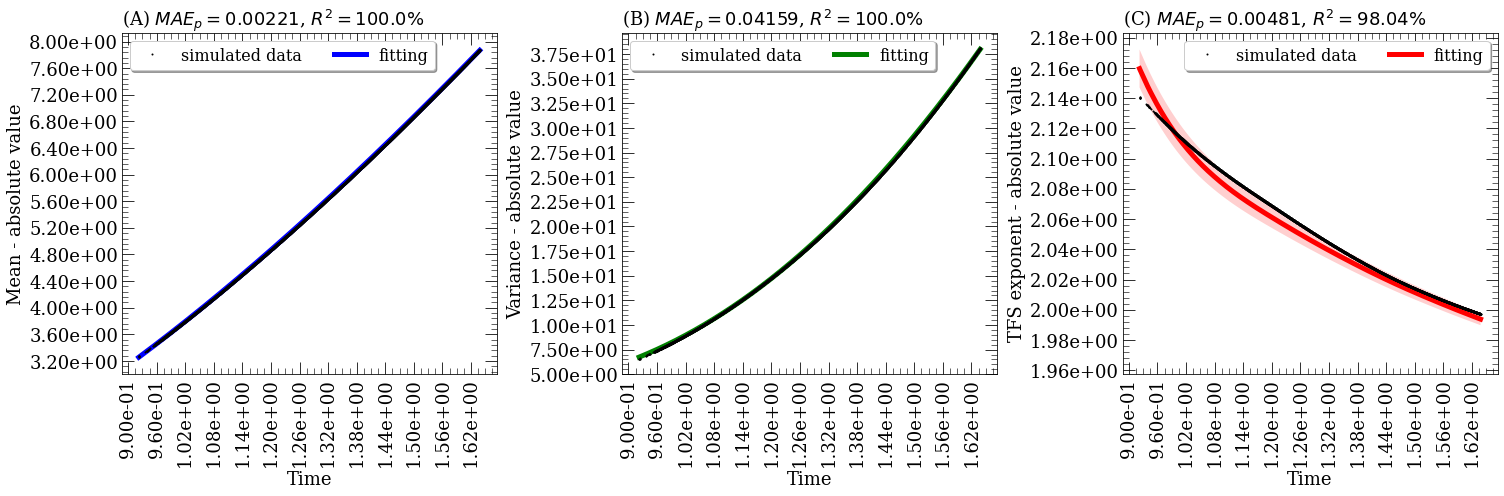

In [15]:
df_final_toy_model = plot_tfs_toy_model(
    df_fts = df_toy_model,
    df_tfs = df_toy_model_parameters,
    interval = "days",
    threshold = 0.99,
    symbols = ["BML_simulation"],
    mu = mu / 2,
    b0 = b0 / 2,
    sigma = sigma,
    p_norm = 1,
    width = 21,
    height = 7,
    markersize = 1,
    fontsize_labels = 18,
    fontsize_legend = 16,
    usetex = False,
    n_cols = 4,
    n_x_breaks = 15,
    n_y_breaks = 15,
    fancy_legend = True,
    dpi = 150,
    save_figures = True,
    output_path = "{}/{}".format(output_path, re.sub("-", "", input_generation_date)),
    information_name = "BML_simulation",
    input_generation_date = input_generation_date
)

In [16]:
df_final_toy_model

,symbol,time_series,type,mu,b0,sigma,error_mu,error_b0,error_sigma,average_error,rsquared
0,BML_simulation,absolute value,mean,12.706607,-16.821431,3.300000,0.003966,0.017061,0.009945,0.002213,100.00
1,BML_simulation,absolute value,variance,-4.852689,11.347456,14.803362,0.001314,0.002500,0.011886,0.041589,100.00
2,BML_simulation,absolute value,tfs,NaN,NaN,NaN,NaN,NaN,NaN,0.004813,98.04
